In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset, Dataset
import matplotlib.pyplot as plt
import os
import random
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset
from PIL import Image



In [50]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


class CustomScrabbleDataset(Dataset):
    def __init__(self, root_dir, split='training', transform=None):
        """
        Args:
            root_dir (str): Path to dataset root.
            split (str): 'training' or 'val'.
            transform (callable, optional): Optional transform to apply to images.
        """
        self.samples = []
        self.labels = []
        self.class_to_idx = {}
        self.transform = transform

        # Each class folder (A, B, ...)
        for idx, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_path = os.path.join(root_dir, class_name, split)
            if not os.path.isdir(class_path):
                continue

            self.class_to_idx[class_name] = idx

            for fname in os.listdir(class_path):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append(os.path.join(class_path, fname))
                    self.labels.append(idx)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_path = self.samples[idx]
        label = self.labels[idx]

        # Load the image using PIL
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label



# def split_clean_and_augmented(dataset, val_ratio=0.2, exclude_token="augmented"):
#     clean_indices = []
#     augmented_indices = []

#     for i, (path, label) in enumerate(dataset.samples):
#         if exclude_token in os.path.normpath(path).split(os.sep):
#             augmented_indices.append(i)
#         else:
#             clean_indices.append(i)

#     # Shuffle and split the clean data into train/val
#     random.shuffle(clean_indices)
#     val_size = int(val_ratio * len(clean_indices))
#     val_indices = clean_indices[:val_size]
#     train_indices = clean_indices[val_size:] + augmented_indices  # Include augmented only in train

#     return Subset(dataset, train_indices), Subset(dataset, val_indices)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load all images (ImageFolder will recurse into subfolders)
# dataset = datasets.ImageFolder(root='data', transform=transform)

# # Perform the smart split
# train_dataset, val_dataset = split_clean_and_augmented(dataset, val_ratio=0.2)

# # DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

train_dataset = CustomScrabbleDataset('data', split='training', transform=transform)
val_dataset = CustomScrabbleDataset('data', split='val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

class_names = [
    'A', 'B', 'C', 'D', 'E', 'F', 'G',
    'H', 'I', 'J', 'K', 'L', 'M', 'N',
    'O', 'P', 'Q', 'R', 'S', 'T', 'U',
    'V', 'W', 'X', 'Y', 'Z'
]


In [34]:
class LetterClassifier(nn.Module):
    def __init__(self):
        super(LetterClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, len(class_names))

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(-1, 64 * 5 * 5)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LetterClassifier().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 2.3934
Epoch 2, Loss: 1.3578
Epoch 3, Loss: 1.0229
Epoch 4, Loss: 0.7932
Epoch 5, Loss: 0.6501
Epoch 6, Loss: 0.4928
Epoch 7, Loss: 0.3781
Epoch 8, Loss: 0.2758
Epoch 9, Loss: 0.1833
Epoch 10, Loss: 0.1224
Epoch 11, Loss: 0.0752
Epoch 12, Loss: 0.0452
Epoch 13, Loss: 0.0251
Epoch 14, Loss: 0.0147
Epoch 15, Loss: 0.0094
Epoch 16, Loss: 0.0066
Epoch 17, Loss: 0.0046
Epoch 18, Loss: 0.0039
Epoch 19, Loss: 0.0032
Epoch 20, Loss: 0.0027
Epoch 21, Loss: 0.0023
Epoch 22, Loss: 0.0020
Epoch 23, Loss: 0.0018
Epoch 24, Loss: 0.0016
Epoch 25, Loss: 0.0014
Epoch 26, Loss: 0.0013
Epoch 27, Loss: 0.0012
Epoch 28, Loss: 0.0011
Epoch 29, Loss: 0.0010
Epoch 30, Loss: 0.0009
Epoch 31, Loss: 0.0008
Epoch 32, Loss: 0.0008
Epoch 33, Loss: 0.0007
Epoch 34, Loss: 0.0007
Epoch 35, Loss: 0.0006
Epoch 36, Loss: 0.0006
Epoch 37, Loss: 0.0005
Epoch 38, Loss: 0.0005
Epoch 39, Loss: 0.0005
Epoch 40, Loss: 0.0004
Epoch 41, Loss: 0.0004
Epoch 42, Loss: 0.0004
Epoch 43, Loss: 0.0004
Epoch 44, Loss: 0.00

In [52]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 96.16%


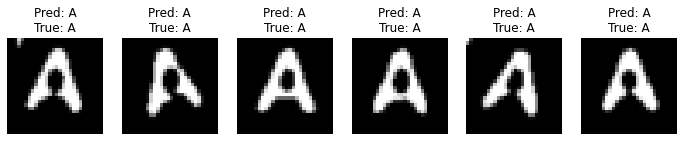

In [53]:
def imshow(img):
    img = img * 0.5 + 0.5  # unnormalize
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')

dataiter = iter(val_loader)
images, labels = next(dataiter)
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Show first 6 images
plt.figure(figsize=(12, 4))
for idx in range(6):
    plt.subplot(1, 6, idx+1)
    imshow(images[idx])
    plt.title(f"Pred: {class_names[preds[idx]]}\nTrue: {class_names[labels[idx]]}")


In [54]:
torch.save(model.state_dict(), 'letter_classifier.pth')
